# Introduction

Here I'm testing the A2C on the new york graph


### First test the optimal cab

In [25]:
import networkx as nx
import csv
import copy
import funcs as f
import numpy as np
import matplotlib.pyplot as plt
import gym
from agent_taxi import Agent
from agent_taxi import PolicyCab
from taxi_environment import Env
from keras.utils import to_categorical

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

%matplotlib inline



#Environment
G = f.load_manhattan_graph()
G = nx.convert_node_labels_to_integers(G)  #nodes start at 1, want them to start at 0
state_zero = np.array([1 if i == 0 else 0 for i in range(G.number_of_nodes())])
env = Env(G,state_zero)


#Agent
p = np.array([G.nodes[i]['prob'] for i in range(G.number_of_nodes())])
optimal_policy = f.find_optimal_policy(p,G)
model_cab = PolicyCab(optimal_policy,G)


taus = []
num_episodes, time_per_episode = 10, 10**3
for episode in range(num_episodes):
    
    state = state_zero
    while model_cab.active_time <= time_per_episode:
        action = model_cab.act(state)
        next_state, reward = env.step(action,model_cab)
        state = next_state
    tau = model_cab.find_tau()
    taus.append(tau)
    print '(episode, tau) = ' + str((episode,model_cab.find_tau()))
    model_cab.reset_clocks()
tau_optimal = np.mean(taus)
tau_optimal

(episode, tau) = (0, 0.18681318681318682)
(episode, tau) = (1, 0.15784215784215785)
(episode, tau) = (2, 0.21078921078921078)
(episode, tau) = (3, 0.18681318681318682)
(episode, tau) = (4, 0.16283716283716285)
(episode, tau) = (5, 0.15984015984015984)
(episode, tau) = (6, 0.14985014985014986)
(episode, tau) = (7, 0.22577422577422576)
(episode, tau) = (8, 0.14185814185814186)
(episode, tau) = (9, 0.14285714285714285)


0.17252747252747253

### Random cab

In [26]:
#Environment
state_zero = np.array([1 if i == 0 else 0 for i in range(G.number_of_nodes())])
env = Env(G,state_zero)
model_cab = PolicyCab(optimal_policy,G)

num_episodes, time_per_episode = 10, 10**3
taus = []
for episode in range(num_episodes):
    
    state = state_zero
    while model_cab.active_time <= time_per_episode:
        state_scalar = np.where(state==1)[0][0]
        neighbours = G[state_scalar].keys()
        action = np.random.choice(range(len(neighbours)))
        next_state, reward = env.step(action,model_cab)
        state = next_state
    tau = model_cab.find_tau()
    taus.append(tau)
    print '(episode, tau) = ' + str((episode,tau))
    model_cab.reset_clocks()
tau_random = np.mean(taus)

(episode, tau) = (0, 0.26573426573426573)
(episode, tau) = (1, 0.26173826173826176)
(episode, tau) = (2, 0.21878121878121878)
(episode, tau) = (3, 0.22877122877122877)
(episode, tau) = (4, 0.2857142857142857)
(episode, tau) = (5, 0.23076923076923078)
(episode, tau) = (6, 0.23276723276723277)
(episode, tau) = (7, 0.26973026973026976)
(episode, tau) = (8, 0.2957042957042957)
(episode, tau) = (9, 0.25874125874125875)


### RL agent

(episode, tau, score) = (50, 0.385, -28024.0)
(episode, tau, score) = (100, 0.232, -7645.0)
(episode, tau, score) = (150, 0.237, -512.0)
(episode, tau, score) = (200, 0.247, -37.0)
(episode, tau, score) = (250, 0.153, 97.0)
(episode, tau, score) = (300, 0.196, 44.0)
(episode, tau, score) = (350, 0.201, 39.0)
(episode, tau, score) = (400, 0.2, 10.0)
(episode, tau, score) = (450, 0.168, 132.0)
(episode, tau, score) = (500, 0.207, 33.0)
(episode, tau, score) = (550, 0.26, -30.0)
(episode, tau, score) = (600, 0.246, -16.0)
(episode, tau, score) = (650, 0.207, 43.0)
(episode, tau, score) = (700, 0.223, 47.0)
(episode, tau, score) = (750, 0.155, 65.0)
(episode, tau, score) = (800, 0.122, 148.0)
(episode, tau, score) = (850, 0.133, 127.0)
(episode, tau, score) = (900, 0.155, 115.0)
(episode, tau, score) = (950, 0.129, 151.0)
(episode, tau, score) = (1000, 0.156, 54.0)
(episode, tau, score) = (1050, 0.131, 119.0)
(episode, tau, score) = (1100, 0.222, 18.0)
(episode, tau, score) = (1150, 0.172,

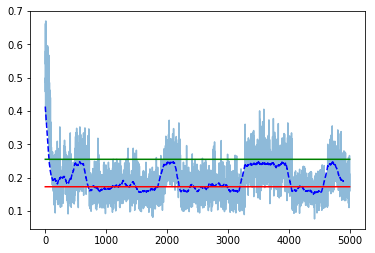

In [30]:
EPISODES = 5000


#Environment
state_zero = np.array([1 if i == 0 else 0 for i in range(G.number_of_nodes())])
env = Env(G,state_zero)
num_states = env.num_states
num_actions = env.num_actions
env.illegal_move_penalty = -100.0
env.pickup_reward = 10.0

#Agent
lr = 0.001
gamma = 0.01
agent = Agent(num_states, num_actions, lr, gamma)
agent.memory_size = 1000

scores = []

for e in range(1,EPISODES+1):
    state = state_zero
    state = np.reshape(state, [1, num_states])
    reward_sum = 0
    while agent.active_time < time_per_episode:
        
        # env.render()
        action = agent.act(state)
        next_state, reward = env.step(action,agent)
        reward_sum += reward
        next_state = np.reshape(next_state, [1, num_states])
        
        #We only want to remember action taken when looking
        if agent.state == 'serving':
            pass
        else:
            agent.remember(state[0], action, 1.0*reward)
        state = next_state
    
    #Learn & print results
    agent.train_models()
    tau = agent.find_tau()
    scores.append(tau)
    agent.reset_clocks()
    if e % 50 == 0:
        print '(episode, tau, score) = ' + str((e,tau,reward_sum))

        
plt.plot(scores,alpha=0.5)
plt.plot(running_mean(scores,100),'b--')   #100 = window size
plt.plot([tau_random for i in scores],'g-')
plt.plot([tau_optimal for i in scores],'r-')
#np.savetxt('stats/scores_lunar_landing.txt',scores)

Interesting oscillations -- I could smooth those out with PPO

### Test the (deterministic) policy

In [31]:
#Check the policy

policy = {}
for state_scalar in range(num_states):
    state_vec = np.array([[1 if i == state_scalar else 0 for i in range(G.number_of_nodes())]])
    action_probs = agent.actor.model.predict(state_vec)[0]
    print action_probs
    best_action = np.argmax(action_probs)
    best_action = 0
    neighbours = G[state_scalar].keys()
    policy[state_scalar] = neighbours[best_action]

[1.00000000e+00 2.14877713e-10 3.56186326e-13 2.70586826e-14
 1.01195805e-14 5.71404403e-16 4.46521690e-17]
[1.0000000e+00 5.7920130e-10 1.2189363e-12 3.5499246e-14 1.4222933e-14
 8.7023138e-16 8.6550336e-17]
[1.0000000e+00 2.6699065e-09 9.2599097e-12 9.5396607e-13 3.9330242e-13
 3.1582054e-14 3.1914177e-15]
[1.0000000e+00 6.0661465e-10 1.3145349e-12 6.3574600e-14 2.4405884e-14
 1.5929621e-15 1.4195573e-16]
[1.0000000e+00 9.3328527e-09 4.3718886e-11 3.7362357e-12 1.6756523e-12
 1.5263035e-13 1.9126131e-14]
[1.0000000e+00 1.6519811e-09 4.7142242e-12 2.0874354e-13 8.6459723e-14
 6.1957288e-15 6.6253737e-16]
[1.0000000e+00 3.8250771e-09 1.4350401e-11 7.6149417e-13 3.2813921e-13
 2.6456383e-14 3.0520638e-15]
[1.0000000e+00 5.3581388e-09 2.2496827e-11 1.2707490e-12 5.4975414e-13
 4.7322552e-14 5.5041035e-15]
[1.0000000e+00 3.3730876e-10 5.9722957e-13 2.3399300e-14 8.7949286e-15
 5.2573615e-16 4.4852247e-17]
[1.00000000e+00 3.05590020e-09 1.10379796e-11 6.47556173e-13
 2.74084818e-13 2.17335

[1.0000000e+00 1.5299214e-08 9.2176225e-11 6.8122842e-12 3.2829527e-12
 3.0969267e-13 4.3066475e-14]
[1.0000000e+00 2.1722556e-08 1.3882945e-10 9.8420933e-12 4.7071353e-12
 4.6950909e-13 6.7083004e-14]
[1.0000000e+00 1.1916336e-08 6.6874742e-11 4.8981205e-12 2.3052990e-12
 2.1346319e-13 2.8045334e-14]
[1.00000000e+00 2.57571369e-08 1.80490192e-10 1.35298465e-11
 6.61667336e-12 6.76100777e-13 9.78003079e-14]
[1.0000000e+00 1.8412326e-08 1.1842007e-10 7.7108094e-12 3.7476979e-12
 3.6002698e-13 5.1383824e-14]
[1.0000000e+00 2.4176339e-08 1.6990317e-10 1.1871966e-11 5.8889547e-12
 5.9065117e-13 8.5236912e-14]
[1.0000000e+00 6.9648709e-09 3.3181256e-11 2.0265651e-12 9.2503013e-13
 8.0000920e-14 9.9277123e-15]
[1.0000000e+00 2.0714252e-08 1.3282063e-10 9.6000647e-12 4.6744700e-12
 4.6205899e-13 6.5595180e-14]
[1.0000000e+00 2.9527156e-08 2.2203764e-10 1.6886216e-11 8.4768286e-12
 8.7361872e-13 1.2903560e-13]
[1.0000000e+00 7.2896471e-09 3.5772808e-11 2.4560852e-12 1.1347896e-12
 9.7876067e-1

[1.0000000e+00 2.8921812e-09 1.0478132e-11 7.7690290e-13 3.4058271e-13
 2.6178148e-14 2.9276377e-15]
[1.0000000e+00 7.1098576e-09 3.4292118e-11 2.4367767e-12 1.1144955e-12
 9.7518666e-14 1.1839024e-14]
[1.0000000e+00 1.9514323e-08 1.2630107e-10 1.1205817e-11 5.3132199e-12
 5.3250877e-13 7.1872568e-14]
[1.0000000e+00 2.3052685e-08 1.5595236e-10 1.0323281e-11 5.1084263e-12
 5.0179950e-13 7.4813521e-14]
[1.0000000e+00 6.5004362e-09 3.0190451e-11 2.1481439e-12 9.7237138e-13
 8.4278105e-14 1.0064989e-14]
[1.0000000e+00 1.9868981e-08 1.2832599e-10 1.0060129e-11 4.8128832e-12
 4.7939983e-13 6.6478486e-14]
[1.0000000e+00 1.6079928e-08 9.7772103e-11 6.6618052e-12 3.2163551e-12
 3.0577946e-13 4.2727744e-14]
[1.0000000e+00 3.1902790e-08 2.4595381e-10 1.8438305e-11 9.1269778e-12
 9.5414442e-13 1.4237815e-13]
[1.0000000e+00 1.5227481e-08 8.9509462e-11 6.9029526e-12 3.3213913e-12
 3.1524233e-13 4.3254500e-14]
[1.0000000e+00 1.7164238e-08 1.0454083e-10 7.8627114e-12 3.7415414e-12
 3.6444320e-13 4.989

[1.0000000e+00 1.8018287e-08 1.1376818e-10 8.4300856e-12 3.9920983e-12
 3.9413901e-13 5.3516602e-14]
[1.0000000e+00 2.8163617e-08 2.1134954e-10 1.4324860e-11 7.2217831e-12
 7.3179819e-13 1.0973691e-13]
[1.0000000e+00 2.6232909e-08 1.7905658e-10 1.3195974e-11 6.3684865e-12
 6.5718687e-13 9.4504089e-14]
[1.0000000e+00 4.6858162e-08 4.1200196e-10 3.1363894e-11 1.6535683e-11
 1.7732747e-12 2.8382163e-13]
[1.00000000e+00 1.80986444e-08 1.12606716e-10 7.84895586e-12
 3.77474397e-12 3.69590453e-13 5.11922861e-14]
[1.0000000e+00 2.1403245e-08 1.4245742e-10 9.8928712e-12 4.8283578e-12
 4.8145239e-13 6.7815396e-14]
[1.0000000e+00 2.4164123e-08 1.6292188e-10 1.3321000e-11 6.3875736e-12
 6.5706907e-13 9.2192259e-14]
[1.0000000e+00 2.0130088e-08 1.2981737e-10 1.0241969e-11 4.9068727e-12
 4.9028571e-13 6.7317435e-14]
[1.0000000e+00 2.0192422e-08 1.2632539e-10 8.4182279e-12 3.9680416e-12
 3.9900944e-13 5.5194659e-14]
[1.0000000e+00 2.9092121e-08 2.1300758e-10 1.5866884e-11 7.8353747e-12
 8.1290243e-1

[1.0000000e+00 9.4414068e-09 4.7295015e-11 3.6369551e-12 1.6559725e-12
 1.5049378e-13 1.9007756e-14]
[9.9999988e-01 6.0771420e-08 5.3745020e-10 3.9375614e-11 2.0236111e-11
 2.2627638e-12 3.7498764e-13]
[1.0000000e+00 2.5078116e-08 1.6784882e-10 1.2857166e-11 6.2271338e-12
 6.4095501e-13 9.1040185e-14]
[1.0000000e+00 2.7604033e-08 1.9503810e-10 1.5396556e-11 7.6255703e-12
 7.7498191e-13 1.1505178e-13]
[1.0000000e+00 1.9858600e-08 1.2725257e-10 9.5327175e-12 4.5777492e-12
 4.5672727e-13 6.3358403e-14]
[1.0000000e+00 1.2669688e-08 7.1507453e-11 4.8747365e-12 2.3153549e-12
 2.1393763e-13 2.8728268e-14]
[9.9998844e-01 1.0975921e-05 4.6034808e-07 6.3096408e-08 4.1345711e-08
 9.2803090e-09 2.6968427e-09]
[1.0000000e+00 6.4544765e-09 3.0561127e-11 2.4255225e-12 1.1094626e-12
 9.5324349e-14 1.1516391e-14]
[1.0000000e+00 2.6488374e-08 1.8550277e-10 1.2647047e-11 6.2268723e-12
 6.3589916e-13 9.2858643e-14]
[1.0000000e+00 5.1094698e-08 4.3136442e-10 3.3640205e-11 1.7202361e-11
 1.9090506e-12 3.018

[1.0000000e+00 4.5900951e-08 3.7982631e-10 2.8975784e-11 1.4573051e-11
 1.5973366e-12 2.4865006e-13]
[9.9984181e-01 1.4134683e-04 1.2121708e-05 2.2133684e-06 1.6115303e-06
 5.0330169e-07 1.9494321e-07]
[1.0000000e+00 2.5150014e-08 1.7342051e-10 1.2974105e-11 6.4144089e-12
 6.4492091e-13 9.4635041e-14]
[9.9999416e-01 5.6155091e-06 1.9242135e-07 2.3100792e-08 1.4581664e-08
 3.0246730e-09 8.0985640e-10]
[1.0000000e+00 1.9420826e-08 1.2740752e-10 9.0339897e-12 4.3922049e-12
 4.3256669e-13 6.0157479e-14]
[1.0000000e+00 7.1359154e-09 3.3865723e-11 2.3016875e-12 1.0765306e-12
 9.1497502e-14 1.1715567e-14]
[1.0000000e+00 2.1191973e-08 1.4005314e-10 9.0812739e-12 4.3717694e-12
 4.3718506e-13 6.1812372e-14]
[1.0000000e+00 1.3243524e-08 7.5042299e-11 5.3015179e-12 2.4600892e-12
 2.3479339e-13 3.0481094e-14]
[1.0000000e+00 4.5546762e-09 1.9008692e-11 1.3524988e-12 6.1060814e-13
 4.9877250e-14 5.8656625e-15]
[9.9563855e-01 3.2605948e-03 6.5305375e-04 1.8740536e-04 1.4958081e-04
 7.2215931e-05 3.874

 5.3695248e-13 7.7987482e-14]
[1.0000000e+00 3.2112247e-08 2.3846847e-10 1.9104138e-11 9.3833517e-12
 9.9382178e-13 1.4529574e-13]
[1.00000000e+00 7.16101667e-09 3.48230403e-11 2.47798917e-12
 1.13058976e-12 9.84396009e-14 1.20580764e-14]
[1.0000000e+00 2.0575449e-08 1.3879319e-10 1.1663679e-11 5.7208062e-12
 5.7023380e-13 7.8629432e-14]
[9.9999845e-01 1.5980003e-06 3.8108873e-08 4.0936881e-09 2.4012592e-09
 4.2764048e-10 9.7416596e-11]
[1.0000000e+00 1.1167939e-08 6.2383120e-11 4.4351636e-12 2.0798537e-12
 1.9262403e-13 2.4838306e-14]
[1.0000000e+00 1.7750480e-08 1.1359385e-10 8.4094337e-12 4.0949535e-12
 3.9689478e-13 5.5181079e-14]
[9.9999964e-01 3.0296525e-07 4.5403112e-09 4.2958420e-10 2.3610408e-10
 3.3680062e-11 6.3112037e-12]
[9.9991286e-01 7.9090787e-05 5.9914655e-06 9.8174121e-07 7.0089993e-07
 2.0444773e-07 7.3710972e-08]
[9.9999976e-01 1.8661252e-07 2.3640163e-09 2.1046849e-10 1.1426224e-10
 1.5026988e-11 2.7599073e-12]
[9.9999976e-01 1.8641455e-07 2.4222107e-09 2.2664026e-

 9.1227796e-13 1.3249327e-13]
[9.9999940e-01 6.1524207e-07 1.1213844e-08 1.0532276e-09 6.1094652e-10
 9.3904585e-11 1.9662457e-11]
[1.0000000e+00 5.6653491e-09 2.5522020e-11 1.6670896e-12 7.5781970e-13
 6.3427325e-14 7.6906162e-15]
[9.9999988e-01 1.6747906e-07 1.8837951e-09 1.7501983e-10 9.0744211e-11
 1.1981612e-11 2.0881131e-12]
[1.0000000e+00 1.3825987e-08 8.0584525e-11 6.0899870e-12 2.8258370e-12
 2.7293714e-13 3.5172769e-14]
[1.0000000e+00 3.1480496e-09 1.1622705e-11 7.4371515e-13 3.2912079e-13
 2.5446154e-14 2.8973624e-15]
[1.0000000e+00 1.6115361e-08 9.8807885e-11 7.3142039e-12 3.5235924e-12
 3.3886170e-13 4.6265316e-14]
[9.9992085e-01 7.2266594e-05 5.1960487e-06 8.1615110e-07 5.8042036e-07
 1.6534344e-07 6.0277628e-08]
[1.0000000e+00 7.7845606e-09 3.6646151e-11 2.9289156e-12 1.3365327e-12
 1.1857832e-13 1.4602746e-14]
[9.9591970e-01 3.0669053e-03 6.0526934e-04 1.7129665e-04 1.3667619e-04
 6.5313870e-05 3.4915851e-05]
[1.0000000e+00 1.6137662e-08 1.0146040e-10 7.2424605e-12 3.48

[1.0000000e+00 3.5312897e-08 2.7156666e-10 2.0651772e-11 1.0266260e-11
 1.1041637e-12 1.6151940e-13]
[1.0000000e+00 2.8069380e-09 1.0176444e-11 6.9487748e-13 3.0314247e-13
 2.3399033e-14 2.5729892e-15]
[1.0000000e+00 2.6770264e-08 1.9398261e-10 1.6116412e-11 7.9276143e-12
 8.1996286e-13 1.1688655e-13]
[1.0000000e+00 2.9246623e-08 2.0913202e-10 1.6622833e-11 8.0081757e-12
 8.5338626e-13 1.2010110e-13]
[1.0000000e+00 1.6030993e-08 9.4670570e-11 6.6042163e-12 3.1523469e-12
 3.0403769e-13 4.1404146e-14]
[1.00000000e+00 1.00833315e-08 5.26503181e-11 4.09981424e-12
 1.91624104e-12 1.73768579e-13 2.23298553e-14]
[1.0000000e+00 5.8599245e-08 5.3051241e-10 4.5925312e-11 2.3322653e-11
 2.6639762e-12 4.1599609e-13]
[1.0000000e+00 2.0449741e-08 1.3687615e-10 9.4152091e-12 4.6476304e-12
 4.5396109e-13 6.5346552e-14]
[1.0000000e+00 6.9344366e-09 3.3404082e-11 2.2099256e-12 1.0332575e-12
 8.8215785e-14 1.1104946e-14]
[1.0000000e+00 9.8255271e-09 5.1321315e-11 3.4717708e-12 1.6085172e-12
 1.4664381e-1

[9.9999726e-01 2.5796057e-06 7.3297564e-08 8.0867082e-09 5.0969358e-09
 9.2586394e-10 2.3602878e-10]
[1.0000000e+00 8.5167899e-09 4.4064297e-11 3.0390274e-12 1.4311034e-12
 1.2585431e-13 1.6058640e-14]
[9.9482793e-01 3.8023670e-03 7.9322606e-04 2.3948145e-04 1.9131128e-04
 9.4458264e-05 5.1325707e-05]
[1.00000000e+00 3.84531980e-08 3.02516817e-10 2.20373077e-11
 1.09493655e-11 1.18547403e-12 1.76718937e-13]
[1.0000000e+00 4.9595630e-09 2.1447797e-11 1.4487104e-12 6.6345394e-13
 5.4613981e-14 6.4878438e-15]
[1.0000000e+00 2.9599670e-08 2.1639374e-10 1.5719342e-11 7.7718491e-12
 8.0279766e-13 1.2028909e-13]
[1.0000000e+00 2.5189236e-08 1.7648072e-10 1.3276256e-11 6.5416327e-12
 6.6603916e-13 9.5711315e-14]
[9.9999845e-01 1.5218878e-06 3.6419273e-08 3.9091685e-09 2.3498705e-09
 4.0596368e-10 9.4299006e-11]
[1.000000e+00 6.577626e-09 3.111044e-11 1.887904e-12 8.707607e-13
 7.411686e-14 9.199688e-15]
[1.0000000e+00 1.8070773e-08 1.2001976e-10 9.2929432e-12 4.5531929e-12
 4.4478348e-13 6.092

[1.0000000e+00 2.2302299e-08 1.5502351e-10 1.1670800e-11 5.7335321e-12
 5.6917432e-13 8.1596845e-14]
[1.0000000e+00 1.0681897e-08 5.6067033e-11 3.4801641e-12 1.6480258e-12
 1.4860578e-13 1.9843583e-14]
[1.0000000e+00 1.0194293e-08 5.4450559e-11 4.0024065e-12 1.8798264e-12
 1.7020521e-13 2.2049299e-14]
[1.00000000e+00 2.09533493e-08 1.42713605e-10 1.24520646e-11
 6.04532657e-12 6.04387092e-13 8.35465188e-14]
[1.0000000e+00 5.2417004e-09 2.3064701e-11 1.5478758e-12 6.9650427e-13
 5.8533270e-14 6.8873049e-15]
[1.00000000e+00 3.20685452e-08 2.36108660e-10 2.12409049e-11
 1.04751555e-11 1.10360375e-12 1.63257591e-13]
[1.0000000e+00 1.5968311e-08 9.7831049e-11 6.9177277e-12 3.3679155e-12
 3.1818176e-13 4.4515583e-14]
[9.9999988e-01 1.0547692e-07 1.1231354e-09 9.0079430e-11 4.6987501e-11
 5.7649484e-12 9.8229953e-13]
[1.0000000e+00 1.6550285e-08 1.0272474e-10 6.7024242e-12 3.2333932e-12
 3.0854532e-13 4.3244850e-14]
[1.0000000e+00 2.2514934e-08 1.5204858e-10 1.2267060e-11 5.9484362e-12
 6.009

 6.85321895e-12 6.96772663e-13 1.03164805e-13]
[1.00000000e+00 3.75191114e-08 3.02897873e-10 2.31779509e-11
 1.17256664e-11 1.25427338e-12 1.88111300e-13]
[9.9988139e-01 1.0685451e-04 8.7973149e-06 1.4657297e-06 1.0725759e-06
 3.1808310e-07 1.2264482e-07]
[1.0000000e+00 4.8111033e-08 4.0531442e-10 3.6146610e-11 1.8303541e-11
 2.0437690e-12 3.1160054e-13]
[1.0000000e+00 4.7913044e-08 4.0374887e-10 3.1915096e-11 1.6164100e-11
 1.7841718e-12 2.7828106e-13]
[1.0000000e+00 1.0031652e-08 5.3721735e-11 3.8523963e-12 1.8235860e-12
 1.6344859e-13 2.1330882e-14]
[1.0000000e+00 1.4314148e-08 8.3145088e-11 6.0311951e-12 2.8905719e-12
 2.7348639e-13 3.6893313e-14]
[1.0000000e+00 1.2346135e-08 6.7246826e-11 4.3524420e-12 2.0148408e-12
 1.8921243e-13 2.4803652e-14]
[1.0000000e+00 1.7192678e-08 1.0524366e-10 8.8800148e-12 4.2942338e-12
 4.1406142e-13 5.7544518e-14]
[1.0000000e+00 5.8366226e-08 5.3055288e-10 4.3803020e-11 2.2806557e-11
 2.5421778e-12 4.1302340e-13]
[1.0000000e+00 2.7805362e-08 1.989539

[1.0000000e+00 1.3316346e-08 7.9738563e-11 5.6896081e-12 2.7212948e-12
 2.5534704e-13 3.3861470e-14]
[1.00000000e+00 2.72028320e-08 1.92989139e-10 1.39991109e-11
 6.78105488e-12 7.02819042e-13 1.00993005e-13]
[1.0000000e+00 1.9199693e-08 1.2102086e-10 8.8615547e-12 4.2770839e-12
 4.1824684e-13 5.9098668e-14]
[1.0000000e+00 1.3471773e-08 7.6058479e-11 6.1242565e-12 2.8654965e-12
 2.7380843e-13 3.5619701e-14]
[1.0000000e+00 4.1654182e-08 3.2769315e-10 2.3976269e-11 1.1953400e-11
 1.2960792e-12 1.9986988e-13]
[9.9998856e-01 1.1008273e-05 4.8053920e-07 5.7741278e-08 3.8946791e-08
 8.6077048e-09 2.5507545e-09]
[1.0000000e+00 1.2937355e-08 7.0770549e-11 4.5930460e-12 2.1216722e-12
 2.0051825e-13 2.6485312e-14]
[1.0000000e+00 4.0161927e-09 1.6120563e-11 1.1077372e-12 4.9506688e-13
 4.0084147e-14 4.6038532e-15]
[1.0000000e+00 4.1640838e-08 3.3726053e-10 2.7085369e-11 1.3555987e-11
 1.4807958e-12 2.2503543e-13]
[1.0000000e+00 1.3787118e-08 8.0787821e-11 5.8485122e-12 2.8134621e-12
 2.6205386e-1

 2.1411234e-13 2.7708763e-14]
[9.9999988e-01 6.7197178e-08 6.2800148e-10 4.9640240e-11 2.5475424e-11
 2.9747780e-12 4.7370793e-13]
[9.9999988e-01 6.1636548e-08 5.5031935e-10 4.4745228e-11 2.2507727e-11
 2.5584782e-12 4.1674653e-13]
[1.0000000e+00 1.5747606e-08 9.6849466e-11 7.2800906e-12 3.5201800e-12
 3.3161421e-13 4.6112375e-14]
[1.0000000e+00 8.7100505e-09 4.3606126e-11 3.1690399e-12 1.4517282e-12
 1.3015409e-13 1.6323758e-14]
[1.0000000e+00 5.5115268e-09 2.4055744e-11 1.7240224e-12 7.7174850e-13
 6.5485174e-14 7.7110330e-15]
[9.9999988e-01 1.2090059e-07 1.3190451e-09 1.1535914e-10 6.0318188e-11
 7.5967236e-12 1.2963213e-12]
[1.0000000e+00 2.6428724e-08 1.8491600e-10 1.2851036e-11 6.3264398e-12
 6.4758832e-13 9.4346684e-14]
[1.0000000e+00 1.2151828e-08 7.0044304e-11 4.4550453e-12 2.1411408e-12
 1.9504971e-13 2.6517461e-14]
[1.0000000e+00 1.1566441e-08 6.1425448e-11 4.1191278e-12 1.8876842e-12
 1.7610722e-13 2.2875487e-14]
[1.0000000e+00 2.0865132e-08 1.3971856e-10 1.0673287e-11 5.25

 9.1293932e-13 1.3704889e-13]
[1.0000000e+00 2.3079831e-08 1.5547658e-10 1.2747600e-11 6.1897969e-12
 6.2915276e-13 8.8624590e-14]
[9.94559467e-01 3.98017839e-03 8.39940156e-04 2.57124630e-04
 2.05450124e-04 1.02111044e-04 5.57135863e-05]
[1.0000000e+00 7.0620003e-09 3.2828417e-11 2.1459570e-12 9.9706853e-13
 8.4772074e-14 1.0863229e-14]
[1.0000000e+00 1.9081989e-08 1.2207965e-10 8.8840463e-12 4.2544245e-12
 4.2471173e-13 5.7839862e-14]
[1.0000000e+00 1.2565723e-08 6.9268286e-11 4.5904361e-12 2.1630892e-12
 2.0090643e-13 2.6864605e-14]
[1.0000000e+00 9.9289164e-09 5.3770530e-11 4.0911983e-12 1.9252534e-12
 1.7419964e-13 2.2406095e-14]
[1.0000000e+00 1.4866059e-08 8.8102248e-11 5.7804408e-12 2.7451817e-12
 2.6078589e-13 3.5268029e-14]
[1.0000000e+00 5.7693579e-09 2.5387388e-11 1.7189199e-12 7.7838468e-13
 6.5935362e-14 7.9273305e-15]
[1.0000000e+00 2.9229446e-08 2.0948453e-10 1.5010892e-11 7.3653436e-12
 7.5274737e-13 1.1397369e-13]
[1.0000000e+00 3.7564796e-08 2.9505057e-10 2.2575790e-

[1.0000000e+00 4.5765187e-08 3.8003936e-10 2.9005255e-11 1.4754765e-11
 1.6054828e-12 2.5408533e-13]
[1.0000000e+00 9.2339087e-09 4.7395341e-11 2.8900261e-12 1.3270882e-12
 1.1931429e-13 1.5241296e-14]
[1.0000000e+00 1.4836966e-08 8.8542437e-11 6.0789620e-12 2.9346530e-12
 2.7616391e-13 3.8004291e-14]
[1.0000000e+00 3.1744484e-08 2.3454264e-10 1.8641493e-11 9.2674896e-12
 9.6574517e-13 1.4471879e-13]
[9.9998260e-01 1.6370863e-05 7.7597878e-07 1.1266744e-07 7.4547508e-08
 1.7777650e-08 5.3155484e-09]
[9.9999988e-01 7.1432311e-08 6.7650163e-10 5.9389160e-11 3.0352634e-11
 3.5560877e-12 5.7553105e-13]
[1.0000000e+00 5.5116631e-09 2.3395409e-11 1.5311212e-12 6.9668631e-13
 5.7993520e-14 7.0660073e-15]
[1.0000000e+00 2.1717751e-08 1.4663984e-10 1.1896265e-11 5.8166731e-12
 5.7996538e-13 8.1549859e-14]
[9.9999988e-01 1.4215470e-07 1.5537850e-09 1.5673125e-10 8.0331151e-11
 1.0535084e-11 1.7892766e-12]
[1.0000000e+00 1.0669069e-08 5.7779306e-11 4.0908861e-12 1.9769937e-12
 1.7572437e-13 2.389

[1.0000000e+00 5.0597770e-08 4.2460141e-10 3.9207897e-11 1.9402136e-11
 2.2335543e-12 3.2831512e-13]
[1.0000000e+00 2.6749133e-08 1.8924845e-10 1.4864221e-11 7.3617484e-12
 7.5434711e-13 1.0997935e-13]
[1.0000000e+00 6.1165264e-09 2.8250895e-11 2.1435557e-12 9.8249826e-13
 8.3355198e-14 1.0132753e-14]
[1.0000000e+00 3.4969723e-08 2.6591107e-10 2.1563511e-11 1.0548255e-11
 1.1379454e-12 1.6607795e-13]
[1.0000000e+00 4.1814796e-09 1.6723357e-11 1.0354532e-12 4.5774148e-13
 3.7148998e-14 4.3419299e-15]
[9.9999249e-01 7.2499329e-06 2.8562280e-07 3.7959207e-08 2.4851181e-08
 5.2929181e-09 1.4464735e-09]
[1.0000000e+00 2.4208918e-08 1.6749895e-10 1.2370489e-11 6.0813741e-12
 6.0835755e-13 8.8688842e-14]
[1.0000000e+00 1.1019380e-08 5.9093799e-11 4.2021894e-12 1.9592453e-12
 1.7863297e-13 2.3604875e-14]
[1.0000000e+00 7.1629702e-09 3.4934805e-11 2.6576883e-12 1.2395329e-12
 1.0684275e-13 1.3280997e-14]
[1.0000000e+00 5.5055615e-08 4.7800175e-10 4.1015684e-11 2.0732086e-11
 2.3637878e-12 3.639

[9.9999988e-01 6.7724336e-08 6.1666827e-10 4.5911469e-11 2.3608870e-11
 2.6989845e-12 4.4878519e-13]
[1.0000000e+00 3.3822200e-08 2.6310201e-10 1.9788659e-11 9.9836684e-12
 1.0493047e-12 1.5643654e-13]
[1.0000000e+00 7.6464675e-09 3.7232620e-11 2.4096417e-12 1.1137837e-12
 9.6897174e-14 1.2209617e-14]
[1.0000000e+00 1.5754244e-08 9.7786466e-11 7.6043651e-12 3.6636701e-12
 3.5256612e-13 4.7505050e-14]
[1.0000000e+00 2.0896197e-08 1.3597738e-10 1.0357402e-11 4.9946605e-12
 4.9669085e-13 7.0583330e-14]
[1.00000000e+00 3.98246307e-08 3.32701866e-10 2.65106739e-11
 1.34065675e-11 1.44961148e-12 2.19156846e-13]
[1.0000000e+00 3.7168036e-08 2.9962208e-10 2.1074923e-11 1.0657053e-11
 1.1288918e-12 1.7276293e-13]
[1.0000000e+00 7.0061477e-09 3.3840215e-11 2.1836168e-12 1.0118896e-12
 8.6967143e-14 1.0805903e-14]
[1.0000000e+00 4.8047941e-08 4.2174336e-10 3.1416220e-11 1.5944397e-11
 1.7623029e-12 2.7371391e-13]
[1.0000000e+00 3.4547269e-09 1.3199599e-11 9.5013819e-13 4.2573367e-13
 3.3414288e-1

 1.4419336e-13 1.8178437e-14]
[1.0000000e+00 5.4687533e-08 4.4755841e-10 3.5506070e-11 1.7369021e-11
 1.9890287e-12 3.0722872e-13]
[9.9999988e-01 1.0299700e-07 1.1096271e-09 9.3668857e-11 4.9368495e-11
 6.0311253e-12 1.0193397e-12]
[1.0000000e+00 7.3032718e-09 3.5187384e-11 2.3644552e-12 1.0974534e-12
 9.4268790e-14 1.1984338e-14]
[9.99999881e-01 1.02161366e-07 1.06742537e-09 9.46897005e-11
 4.94307754e-11 5.94623482e-12 1.03747946e-12]
[9.9993443e-01 6.0038099e-05 4.1824087e-06 7.4782770e-07 5.3358059e-07
 1.4935360e-07 5.2139793e-08]
[1.0000000e+00 1.2738578e-08 7.5186281e-11 5.6211880e-12 2.7222395e-12
 2.5042392e-13 3.3823388e-14]
[1.0000000e+00 2.5386507e-08 1.7783333e-10 1.2638896e-11 6.1250861e-12
 6.2860459e-13 9.0378409e-14]
[9.99999404e-01 6.53073698e-07 1.17157066e-08 1.19082799e-09
 6.71298184e-10 1.05805954e-10 2.17286033e-11]
[9.9993575e-01 5.9104892e-05 3.9063730e-06 6.4211429e-07 4.4720781e-07
 1.2651036e-07 4.3429086e-08]
[1.0000000e+00 4.1195996e-08 3.2898825e-10 2.52

 1.0156489e-11 1.8172179e-12]
[1.0000000e+00 7.4665456e-09 3.6306014e-11 2.1659048e-12 1.0277736e-12
 8.7179890e-14 1.1327082e-14]
[1.0000000e+00 1.7999875e-08 1.1360772e-10 8.4780733e-12 4.1265589e-12
 4.0038627e-13 5.6000259e-14]
[1.0000000e+00 3.9025537e-08 3.1808214e-10 2.5651445e-11 1.2766969e-11
 1.4001080e-12 2.0429495e-13]
[1.0000000e+00 1.0763377e-08 5.9009325e-11 4.2703592e-12 2.0153020e-12
 1.8273524e-13 2.4031172e-14]
[1.0000000e+00 1.8382114e-08 1.1594857e-10 8.1741801e-12 3.9081772e-12
 3.8328547e-13 5.3229827e-14]
[9.9999988e-01 7.7089418e-08 7.7690993e-10 6.7656838e-11 3.5875025e-11
 4.1946455e-12 6.8520379e-13]
[1.00000000e+00 2.31602222e-08 1.59015204e-10 1.19662205e-11
 5.97258354e-12 5.91045604e-13 8.68126846e-14]
[1.0000000e+00 8.1130249e-09 4.0196985e-11 2.9452343e-12 1.3537558e-12
 1.1954961e-13 1.5040474e-14]
[1.0000000e+00 1.1818664e-08 6.5529880e-11 4.7217655e-12 2.2512441e-12
 2.0706852e-13 2.7522357e-14]
[1.0000000e+00 2.0920842e-08 1.3725523e-10 9.3538493e-

[1.0000000e+00 1.0151432e-08 5.2760896e-11 3.5371675e-12 1.6626980e-12
 1.4996225e-13 1.9580180e-14]
[1.00000000e+00 1.72836536e-08 1.10252134e-10 7.92205190e-12
 3.88530007e-12 3.67600834e-13 5.25538204e-14]
[9.9999952e-01 4.4932042e-07 6.8084596e-09 7.5691181e-10 4.1180379e-10
 6.1673708e-11 1.2292818e-11]
[1.0000000e+00 1.5890622e-08 9.5149749e-11 6.8345525e-12 3.2414082e-12
 3.1428175e-13 4.2524327e-14]
[1.0000000e+00 3.5571519e-09 1.4078638e-11 1.0201022e-12 4.6074331e-13
 3.6297720e-14 4.1603616e-15]
[1.0000000e+00 1.4621910e-08 8.9779954e-11 7.1180154e-12 3.3984896e-12
 3.2690606e-13 4.2892197e-14]
[1.0000000e+00 2.0930621e-08 1.3952203e-10 1.0643139e-11 5.1584986e-12
 5.1403651e-13 7.2210047e-14]
[1.0000000e+00 5.1297779e-09 2.1879996e-11 1.5602480e-12 7.0471981e-13
 5.7951724e-14 7.0504714e-15]
[1.0000000e+00 9.5414823e-09 5.1283151e-11 3.6509112e-12 1.7074148e-12
 1.5394778e-13 1.9577752e-14]
[1.0000000e+00 1.0664370e-08 5.5563484e-11 3.4781071e-12 1.6186180e-12
 1.4763730e-1

[1.0000000e+00 9.1958920e-09 4.7143348e-11 3.1830090e-12 1.5183803e-12
 1.3279509e-13 1.7487334e-14]
[9.9998057e-01 1.8323553e-05 8.8416357e-07 1.3346150e-07 8.9561993e-08
 2.1327157e-08 6.6021459e-09]
[1.0000000e+00 6.8284125e-09 3.2480008e-11 2.2388604e-12 1.0253730e-12
 8.8535719e-14 1.0908284e-14]
[9.9998569e-01 1.3530352e-05 6.0732697e-07 8.3562632e-08 5.5155414e-08
 1.2735553e-08 3.7624974e-09]
[1.0000000e+00 8.5803142e-09 4.3919975e-11 3.2129275e-12 1.4762668e-12
 1.3388565e-13 1.6257947e-14]
[1.0000000e+00 1.5735505e-08 9.6734454e-11 7.0932813e-12 3.4347479e-12
 3.2594538e-13 4.5263801e-14]
[1.0000000e+00 1.9435017e-08 1.2449458e-10 9.5029817e-12 4.5817937e-12
 4.5311332e-13 6.2766381e-14]
[1.0000000e+00 3.6026009e-08 2.8349204e-10 2.1193354e-11 1.0658497e-11
 1.1311376e-12 1.6956946e-13]
[1.0000000e+00 2.4028999e-08 1.6389931e-10 1.2168764e-11 5.9515344e-12
 6.0045399e-13 8.6366759e-14]
[9.9999988e-01 1.2823259e-07 1.4638279e-09 1.2099684e-10 6.4977634e-11
 8.0786385e-12 1.432

[1.00000000e+00 2.70089568e-08 1.89097266e-10 1.27828555e-11
 6.35001340e-12 6.45543623e-13 9.58454033e-14]
[9.9999976e-01 2.0221528e-07 2.7089420e-09 2.3057582e-10 1.2705173e-10
 1.6726448e-11 3.1375479e-12]
[9.9999857e-01 1.3873874e-06 3.2214590e-08 3.2180183e-09 1.9484716e-09
 3.2962152e-10 7.7040395e-11]
[1.0000000e+00 1.6709578e-08 1.0316437e-10 7.2120101e-12 3.4490134e-12
 3.3778663e-13 4.5448241e-14]
[1.0000000e+00 2.0813500e-08 1.3988281e-10 1.0176871e-11 4.9729682e-12
 4.8990244e-13 6.9550160e-14]
[1.0000000e+00 1.7488823e-08 1.0894002e-10 8.8394743e-12 4.2152662e-12
 4.1590012e-13 5.5676275e-14]
[1.0000000e+00 5.7495107e-08 5.2523463e-10 4.2249110e-11 2.1333152e-11
 2.4590570e-12 3.7955053e-13]
[1.00000000e+00 1.67390208e-08 1.03170666e-10 7.87473298e-12
 3.79121691e-12 3.66194244e-13 5.01063797e-14]
[1.0000000e+00 3.0849257e-08 2.2839609e-10 1.7562269e-11 8.6557818e-12
 9.1129881e-13 1.3301513e-13]
[1.0000000e+00 2.8051610e-09 1.0132807e-11 5.9966311e-13 2.6180409e-13
 2.017

[1.0000000e+00 2.0054935e-08 1.2887370e-10 1.0110567e-11 4.8112768e-12
 4.8373886e-13 6.6116458e-14]
[9.99999881e-01 1.05062895e-07 1.12480114e-09 1.11424786e-10
 5.83610105e-11 7.21809158e-12 1.21125332e-12]
[9.9999976e-01 2.1758784e-07 2.9466372e-09 2.5324090e-10 1.4056105e-10
 1.8653865e-11 3.5262674e-12]
[9.94428039e-01 4.07148339e-03 8.62062443e-04 2.64404254e-04
 2.11255276e-04 1.05309744e-04 5.76529419e-05]
[9.9999809e-01 1.9144604e-06 4.7116810e-08 5.9927787e-09 3.5375172e-09
 6.3857769e-10 1.4490158e-10]
[9.9951327e-01 4.1382588e-04 5.2741714e-05 9.1507427e-06 7.1647542e-06
 2.5704148e-06 1.1363173e-06]
[9.9979287e-01 1.8292453e-04 1.7039540e-05 3.4258892e-06 2.5200791e-06
 8.1529453e-07 3.2593945e-07]
[9.9624240e-01 2.8273501e-03 5.5531238e-04 1.5783848e-04 1.2603463e-04
 5.9716731e-05 3.1355779e-05]
[1.0000000e+00 1.2871171e-08 7.1902845e-11 4.6619154e-12 2.2003571e-12
 2.0367205e-13 2.7654171e-14]
[1.0000000e+00 3.9288206e-08 3.0507855e-10 2.3422734e-11 1.1462718e-11
 1.256

[1.0000000e+00 1.3828993e-08 7.9145197e-11 5.5542263e-12 2.5986843e-12
 2.4975042e-13 3.2639313e-14]
[1.0000000e+00 1.1576218e-08 6.5108655e-11 4.5262813e-12 2.1358221e-12
 1.9716378e-13 2.6003625e-14]
[1.0000000e+00 1.8974417e-08 1.2096502e-10 9.3240493e-12 4.4496360e-12
 4.4231483e-13 6.0374388e-14]
[1.00000000e+00 1.19547865e-08 6.76878206e-11 5.22189453e-12
 2.47221080e-12 2.28002269e-13 3.00955414e-14]
[1.0000000e+00 1.5280435e-08 9.2889425e-11 6.1753632e-12 2.9771624e-12
 2.8171120e-13 3.9120735e-14]
[1.0000000e+00 2.0092878e-08 1.3305720e-10 8.8531422e-12 4.3212244e-12
 4.2712042e-13 5.9696050e-14]
[9.9990988e-01 8.1900289e-05 6.0889865e-06 1.0739739e-06 7.6767947e-07
 2.2367009e-07 8.0876710e-08]
[1.0000000e+00 2.2043311e-08 1.4768879e-10 1.1132320e-11 5.3943286e-12
 5.4454970e-13 7.5531710e-14]
[1.0000000e+00 2.8120622e-08 2.0357140e-10 1.5364168e-11 7.5176350e-12
 7.8891765e-13 1.1165652e-13]
[1.00000000e+00 1.29500695e-08 7.48807336e-11 5.28552462e-12
 2.51413777e-12 2.34393

[1.0000000e+00 8.1241742e-09 4.1361903e-11 2.8142727e-12 1.3252644e-12
 1.1551728e-13 1.4712590e-14]
[1.0000000e+00 4.3333081e-08 3.6314066e-10 2.8997455e-11 1.4686677e-11
 1.6162117e-12 2.4398449e-13]
[1.0000000e+00 2.2652257e-08 1.5459684e-10 1.2073237e-11 5.8922017e-12
 5.9604264e-13 8.3866792e-14]
[1.0000000e+00 5.7255992e-08 5.0322840e-10 3.8678449e-11 1.9755095e-11
 2.2151330e-12 3.5759129e-13]
[1.0000000e+00 2.2171708e-08 1.4879574e-10 1.0658863e-11 5.1940514e-12
 5.1979731e-13 7.3597053e-14]
[1.0000000e+00 3.1779745e-08 2.3292257e-10 1.7991129e-11 8.9214547e-12
 9.3322821e-13 1.3947179e-13]
[1.0000000e+00 3.9933937e-08 3.1838623e-10 2.2184152e-11 1.1317662e-11
 1.1991439e-12 1.8927703e-13]
[1.0000000e+00 6.3171406e-09 2.8988275e-11 1.8198021e-12 8.3415994e-13
 7.0510397e-14 8.8156868e-15]
[1.0000000e+00 3.1163463e-08 2.3045540e-10 1.6640979e-11 8.1372660e-12
 8.5936613e-13 1.2607847e-13]
[1.0000000e+00 3.9023282e-09 1.5761946e-11 1.1238345e-12 5.0308558e-13
 4.0367029e-14 4.629

[9.9999952e-01 5.1224237e-07 9.1932568e-09 1.0478657e-09 6.0957084e-10
 9.1255864e-11 1.8481921e-11]
[1.00000000e+00 1.73917236e-08 1.06106325e-10 7.32573637e-12
 3.43168983e-12 3.38691748e-13 4.58109841e-14]
[9.9866199e-01 1.0818286e-03 1.6779556e-04 3.8940092e-05 3.0800213e-05
 1.2633151e-05 6.1013538e-06]
[9.9997365e-01 2.4708628e-05 1.3206009e-06 1.8208490e-07 1.2481854e-07
 3.0914471e-08 9.9085256e-09]
[9.9439234e-01 4.0932847e-03 8.6859328e-04 2.6731397e-04 2.1359762e-04
 1.0657095e-04 5.8343907e-05]
[1.0000000e+00 1.1757553e-08 6.6970984e-11 4.8182565e-12 2.3042000e-12
 2.1083305e-13 2.8024319e-14]
[1.00000000e+00 7.39398498e-09 3.44216704e-11 2.00849450e-12
 9.29318688e-13 7.93495857e-14 1.03175965e-14]
[1.0000000e+00 1.6086831e-08 9.8010537e-11 6.7474329e-12 3.2583552e-12
 3.0937858e-13 4.3415016e-14]
[1.0000000e+00 1.2144275e-08 6.8226515e-11 5.0312614e-12 2.4053207e-12
 2.2105652e-13 2.9639692e-14]
[1.0000000e+00 4.0015291e-08 3.2463612e-10 2.8596176e-11 1.4221410e-11
 1.562

[9.9762988e-01 1.8611046e-03 3.2490838e-04 7.8989331e-05 6.2869156e-05
 2.7796968e-05 1.4348485e-05]
[1.0000000e+00 1.4159990e-08 8.4511800e-11 6.2195843e-12 2.9535094e-12
 2.8034812e-13 3.7397253e-14]
[1.00000000e+00 4.09795433e-08 3.26396910e-10 2.69980479e-11
 1.34443125e-11 1.46619555e-12 2.21904784e-13]
[1.0000000e+00 2.8824681e-08 2.0646938e-10 1.6788331e-11 8.3407769e-12
 8.5287859e-13 1.2778357e-13]
[1.0000000e+00 2.3733792e-08 1.5602288e-10 1.2144743e-11 5.7975335e-12
 5.9587892e-13 8.3834645e-14]
[1.0000000e+00 5.7591660e-09 2.6497884e-11 1.8060847e-12 8.3959987e-13
 6.9398568e-14 8.6542169e-15]
[1.0000000e+00 7.9756743e-09 3.7899680e-11 2.6447076e-12 1.2112465e-12
 1.0548426e-13 1.3510536e-14]
[1.0000000e+00 1.3494996e-08 7.5334280e-11 6.1535174e-12 2.9318221e-12
 2.7151911e-13 3.7226099e-14]
[9.9911207e-01 7.3325500e-04 1.0230062e-04 2.3662040e-05 1.8257268e-05
 7.1567570e-06 3.2927157e-06]
[9.9999917e-01 8.7162255e-07 1.7740719e-08 1.7683042e-09 1.0430100e-09
 1.6697950e-1

[1.0000000e+00 7.8186364e-09 3.9329609e-11 2.9195956e-12 1.3736745e-12
 1.1921193e-13 1.5048882e-14]
[1.0000000e+00 1.0254514e-08 5.5998421e-11 4.0876105e-12 1.9209543e-12
 1.7443138e-13 2.2350692e-14]
[1.0000000e+00 5.8908061e-09 2.5729504e-11 1.9006036e-12 8.5622151e-13
 7.2577198e-14 8.7297824e-15]
[1.0000000e+00 4.0351292e-08 3.1547079e-10 2.4709252e-11 1.2114251e-11
 1.3346578e-12 1.9733797e-13]
[1.0000000e+00 5.7157351e-08 4.9446552e-10 4.0788817e-11 2.0402180e-11
 2.3469364e-12 3.6503802e-13]
[1.0000000e+00 4.0485279e-08 3.2774064e-10 2.5638923e-11 1.2886160e-11
 1.3910684e-12 2.1311575e-13]
[1.0000000e+00 4.2131767e-08 3.3919587e-10 2.6954414e-11 1.3469234e-11
 1.4688071e-12 2.2434759e-13]
[1.0000000e+00 1.5968068e-08 9.9777339e-11 6.7735318e-12 3.2521154e-12
 3.1030050e-13 4.2625181e-14]
[1.0000000e+00 2.5549237e-08 1.7435348e-10 1.2254642e-11 6.0552973e-12
 6.0446434e-13 9.1740404e-14]
[9.9999988e-01 6.3606322e-08 5.7260185e-10 4.5666578e-11 2.3030014e-11
 2.6818246e-12 4.201

[1.00000000e+00 2.34817268e-08 1.60240071e-10 1.24250185e-11
 6.10302217e-12 6.12775889e-13 8.84803434e-14]
[1.0000000e+00 1.3569822e-08 7.5353390e-11 4.8103869e-12 2.2678625e-12
 2.1408008e-13 2.8704879e-14]
[1.0000000e+00 1.6481989e-08 9.9105349e-11 6.4293766e-12 3.0815378e-12
 2.9315019e-13 4.1399725e-14]
[9.9669695e-01 2.5218450e-03 4.7640436e-04 1.2899408e-04 1.0285335e-04
 4.7725174e-05 2.5068462e-05]
[1.0000000e+00 1.1785978e-08 6.4784102e-11 4.5326568e-12 2.1316913e-12
 1.9732253e-13 2.5938189e-14]
[9.9853230e-01 1.1710158e-03 1.9062019e-04 4.6370918e-05 3.6764577e-05
 1.5465355e-05 7.3427050e-06]
[1.0000000e+00 2.1696387e-08 1.4749961e-10 1.0555863e-11 5.1677855e-12
 5.1293469e-13 7.3997225e-14]
[1.0000000e+00 6.0293179e-09 2.6990066e-11 1.7582772e-12 8.0627643e-13
 6.8344019e-14 8.3155071e-15]
[1.0000000e+00 1.8043254e-08 1.1201548e-10 8.2460566e-12 3.9316614e-12
 3.8790783e-13 5.2898864e-14]
[1.0000000e+00 4.7904338e-09 1.9953298e-11 1.1705929e-12 5.3210870e-13
 4.3351631e-1

 6.8544703e-13 9.7921630e-14]
[1.0000000e+00 5.8433169e-08 5.3077154e-10 4.3434794e-11 2.2295417e-11
 2.5245702e-12 4.0028164e-13]
[1.0000000e+00 2.1859423e-08 1.4858276e-10 1.2427436e-11 5.9882563e-12
 6.0465115e-13 8.4194716e-14]
[1.0000000e+00 1.2725659e-08 7.3562496e-11 5.7672257e-12 2.7118128e-12
 2.5953098e-13 3.2855615e-14]
[1.0000000e+00 1.8548562e-08 1.1885998e-10 8.8017553e-12 4.2592149e-12
 4.1703126e-13 5.7628984e-14]
[1.0000000e+00 1.3147983e-08 7.5647016e-11 5.4227282e-12 2.5560298e-12
 2.4149685e-13 3.1836130e-14]
[1.0000000e+00 2.8142997e-08 2.1288370e-10 1.9203143e-11 9.5272826e-12
 9.8482659e-13 1.4238385e-13]
[9.9961531e-01 3.3100703e-04 3.7055102e-05 7.8040966e-06 5.8963378e-06
 2.0858520e-06 8.7024080e-07]
[1.0000000e+00 2.3026978e-08 1.6230220e-10 1.1337539e-11 5.5103517e-12
 5.5777388e-13 7.8056085e-14]
[1.0000000e+00 4.3022602e-08 3.4993375e-10 3.0237129e-11 1.5004251e-11
 1.6526341e-12 2.4920699e-13]
[1.0000000e+00 1.6233239e-08 9.8762852e-11 7.1421818e-12 3.41

[1.00000000e+00 1.81405664e-08 1.10142624e-10 8.41801889e-12
 3.98183223e-12 3.92900556e-13 5.34729325e-14]
[1.00000000e+00 2.29172201e-08 1.58291977e-10 1.14440185e-11
 5.53728114e-12 5.61605179e-13 7.84813973e-14]
[1.0000000e+00 1.8740558e-08 1.2307423e-10 9.9809076e-12 4.7728791e-12
 4.7035341e-13 6.4468443e-14]
[9.9996746e-01 3.0318763e-05 1.7312357e-06 2.6348303e-07 1.8002252e-07
 4.6181167e-08 1.4986940e-08]
[9.9999392e-01 5.8816572e-06 1.8132197e-07 2.5604695e-08 1.5710398e-08
 3.1533429e-09 8.9833757e-10]
[9.9999988e-01 8.4004562e-08 8.7068719e-10 7.0611975e-11 3.7374132e-11
 4.3958500e-12 7.3952942e-13]
[1.0000000e+00 1.7442551e-08 1.0659519e-10 6.5504850e-12 3.1546564e-12
 3.0360653e-13 4.2748940e-14]
[1.0000000e+00 6.7688797e-09 3.1148441e-11 2.2949761e-12 1.0386081e-12
 9.0283995e-14 1.0913945e-14]
[1.0000000e+00 2.7788980e-08 1.9715581e-10 1.3451597e-11 6.6046825e-12
 6.8240498e-13 9.9417395e-14]
[1.0000000e+00 8.4628509e-09 4.1075653e-11 2.5834627e-12 1.1929661e-12
 1.052

[1.0000000e+00 3.1892689e-08 2.4089042e-10 1.8903911e-11 9.4119591e-12
 9.8263129e-13 1.4620590e-13]
[9.9999917e-01 8.6802987e-07 1.4845475e-08 1.5600468e-09 8.6653479e-10
 1.3731666e-10 3.0906725e-11]
[1.0000000e+00 2.6612343e-08 1.9096097e-10 1.4776930e-11 7.2909291e-12
 7.5063263e-13 1.0689717e-13]
[1.0000000e+00 2.4292081e-08 1.6826360e-10 1.4168127e-11 6.8350217e-12
 7.0265283e-13 9.8090806e-14]
[1.0000000e+00 2.4511809e-08 1.7782689e-10 1.2992976e-11 6.3981576e-12
 6.4922080e-13 9.2712106e-14]
[1.0000000e+00 3.8754571e-08 3.1210423e-10 2.4060561e-11 1.1964121e-11
 1.2928646e-12 1.9469920e-13]
[1.0000000e+00 3.7646064e-08 2.9787728e-10 2.3025229e-11 1.1522957e-11
 1.2438860e-12 1.8530232e-13]
[1.0000000e+00 1.6739786e-08 1.0535975e-10 7.9442043e-12 3.8347138e-12
 3.7319889e-13 5.0418427e-14]
[1.0000000e+00 1.3304617e-08 7.7360333e-11 5.3461155e-12 2.5203891e-12
 2.3872476e-13 3.1420548e-14]
[9.9999809e-01 1.9367503e-06 4.8087362e-08 5.5711364e-09 3.3734755e-09
 6.0685301e-10 1.431

In [32]:
deterministic_cab = PolicyCab(policy,G)

taus = []
num_episodes, time_per_episode = 10, 10**4
for episode in range(num_episodes):
    
    state = state_zero
    while deterministic_cab.active_time <= time_per_episode:
        action = deterministic_cab.act(state)
        next_state, reward = env.step(action,deterministic_cab)
        state = next_state
    tau = deterministic_cab.find_tau()
    taus.append(tau)
    print '(episode, tau) = ' + str((episode,deterministic_cab.find_tau()))
    deterministic_cab.reset_clocks()
np.mean(taus)

(episode, tau) = (0, 0.1977802219778022)
(episode, tau) = (1, 0.20457954204579543)
(episode, tau) = (2, 0.1912808719128087)
(episode, tau) = (3, 0.19008099190080993)
(episode, tau) = (4, 0.19768023197680232)
(episode, tau) = (5, 0.18758124187581243)
(episode, tau) = (6, 0.19288071192880712)
(episode, tau) = (7, 0.16348365163483652)
(episode, tau) = (8, 0.1857814218578142)
(episode, tau) = (9, 0.18648135186481352)


0.18976102389761026

I caught it in a bad cycle.